In [ ]:
import numpy as np
from matplotlib import pyplot as plt
from scipy import signal
from tqdm.autonotebook import tqdm

In [2]:
class HHModel():
    def __init__(self, dt = 0.01, iter = 10000):
        self.gK_max = 0.36     # max conductance of K channel
        self.gNa_max = 1.20    # max condutance of Na channel
        self.gl = 0.003        # Leaky channel conductance
        self.E_Na = 50         # Nernst potential of Na channel
        self.E_K = -77         # Nernst potential of K channel
        self.E_l = -54.387     # Nernst potential of leaky channel
        self.C = 0.01          # Membrane conductance
        self.v_monitor = []    # Monitor to append all the voltage values
        self.gNa_monitor = []  # Monitor to append all the Na conductance values
        self.gK_monitor = []   # Monitor to append all the K conductance values
        self.m_monitor = []    # Monitor to append all the values of gating variable m
        self.n_monitor = []    # Monitor to append all the values of gating variable n
        self.h_monitor = []    # Monitor to append all the values of gating variable h
        self.dt = dt           # Time steps, every (100dt = 1 ms by default)
        self.I_app = 0         # Initializing the current, updated when <class_object>.model is run
        self.iter = iter

        self.peak_count = 0    # To count the number of peaks, for part (b)


    def model(self, I_app: float):
        self.I_app = I_app
        '''
        Computes the voltage using Hodgkin Huxeley model
        -------------------------------------------------
        Args:
            I_app: External current (micro-amperes/mm^2)
            dt: Step length for Euler method. Default = 0.01 ms
            iter: Number of iterations. Default = 10000
        Returns:
            v_monitor: voltage
            m: Gating variable
            n: Gating variable
            h: Gating variable
            gNa: Conductance of Na channel
            gK: Conductance of K channel
        --------------------------------------------------
        '''
        v = -64.9964
        m = 0.0530
        h = 0.5960
        n = 0.3177
        dt = self.dt
        iter = self.iter

        for i in range(iter):
            gNa = self.gNa_max * (m**3) * h
            gK = self.gK_max * n**4


            dv = (-gNa * (v - self.E_Na) - gK * (v - self.E_K) - self.gl *(v- self.E_l) + I_app)/self.C
            v = v + dt* dv

            alpha_m = 0.1 * (v + 40) / (1- np.exp(-(v + 40)/10))
            beta_m = 4 * np.exp(-0.0556 * (v + 65))
            alpha_h = 0.07 * (np.exp(-0.05 *(v + 65)))
            beta_h = 1/(1 + np.exp(-0.1 * (v + 35)))
            alpha_n = 0.01 * (v + 55)/(1 - np.exp(-(v + 55)/10))
            beta_n = 0.125 * np.exp(-(v + 65)/80)

            dm = alpha_m * (1 - m) - beta_m * m
            dn = alpha_n * (1 - n) - beta_n * n
            dh = alpha_h * (1 - h) - beta_h * h

            m = m + dt * dm
            n = n + dt * dn
            h = h + dt * dh

            self.v_monitor.append(v)
            self.m_monitor.append(m)
            self.n_monitor.append(n)
            self.h_monitor.append(h)
            self.gNa_monitor.append(gNa)
            self.gK_monitor.append(gK)

            # Checking and counting peaks, i>= 3 to ensure, neighbouring points exist to define a maxima
            if i >= 3:
              # Peak Identfication using adjacent point analysis, Counting peaks of higher than 10mV threshold
              if (self.v_monitor[-2] > self.v_monitor[-1]) and (self.v_monitor[-2] > self.v_monitor[-3]) and (self.v_monitor[-2] > 10):
                  self.peak_count += 1

        return self.v_monitor, self.m_monitor, self.n_monitor, self.h_monitor, self.gNa_monitor, self.gK_monitor, self.peak_count

    # To plot Membrane Voltage vs Time
    def display_VT(self):
      time = np.arange(len(self.v_monitor)) * self.dt

      plt.figure(figsize=(11.5, 6))
      plt.plot(time, self.v_monitor, label='Voltage (mV)')
      plt.xlabel('Time (ms)')
      plt.ylabel('Membrane Voltage (mV)')
      plt.title(f'Membrane Voltage vs Time (I_applied = {self.I_app} μA/mm\u00b2)')
      plt.legend()
      plt.ylim([-85, 60])
      plt.xlim([0,100])
      plt.grid(True)
      plt.show()


    # To plot the variation of Gating Variables vs Time
    def display_GVT(self):
        time = np.arange(len(self.v_monitor)) * self.dt

        with plt.style.context('dark_background'):
            fig, ax = plt.subplots(figsize=(12, 6))
            fig.patch.set_facecolor('#111')
            ax.set_facecolor('#111')

            ax.plot(time, self.m_monitor, label='m', color='white', linewidth=2.25)
            ax.plot(time, self.h_monitor, label='h', color='red',   linewidth=2.25)
            ax.plot(time, self.n_monitor, label='n', color='yellow',     linewidth=2.25)

            ax.set_xlabel('Time (ms)')
            ax.set_ylabel('Gating variables')
            ax.set_ylim(0, 1.05); ax.set_xlim(0, 100)
            ax.grid(True, color='w', alpha=0.15)
            ax.legend(loc='upper right', facecolor='#222', edgecolor='none')

            ax.set_title(f'Gating variables vs Time (I_applied = {self.I_app} μA/mm\u00b2)')
            plt.show()

    # To plot the variation in conductance of the Voltage-Gated Ion Channels with Time
    def display_CT(self):
        time = np.arange(len(self.v_monitor)) * self.dt

        with plt.style.context('dark_background'):
            fig, ax2 = plt.subplots(figsize=(12, 6))
            ax2.set_facecolor('#111')
            fig.patch.set_facecolor('#111')

            ax2.plot(time, self.gNa_monitor, label='gNa', color='yellow',linewidth=2)
            ax2.plot(time, self.gK_monitor, label='gK',  color='magenta',linewidth=2)

            ax2.set_xlabel('Time (ms)')
            ax2.set_ylabel('Conductance (millisiemens/mm\u00b2)')
            ax2.set_ylim(0, 0.4); ax2.set_xlim(0, 100)
            ax2.grid(True, color='w', alpha=0.15)
            ax2.legend(loc='upper right', facecolor='#222', edgecolor='none')
            ax2.set_title(f'Conductance vs Time (I_applied = {self.I_app} μA/mm\u00b2)')
            plt.show()

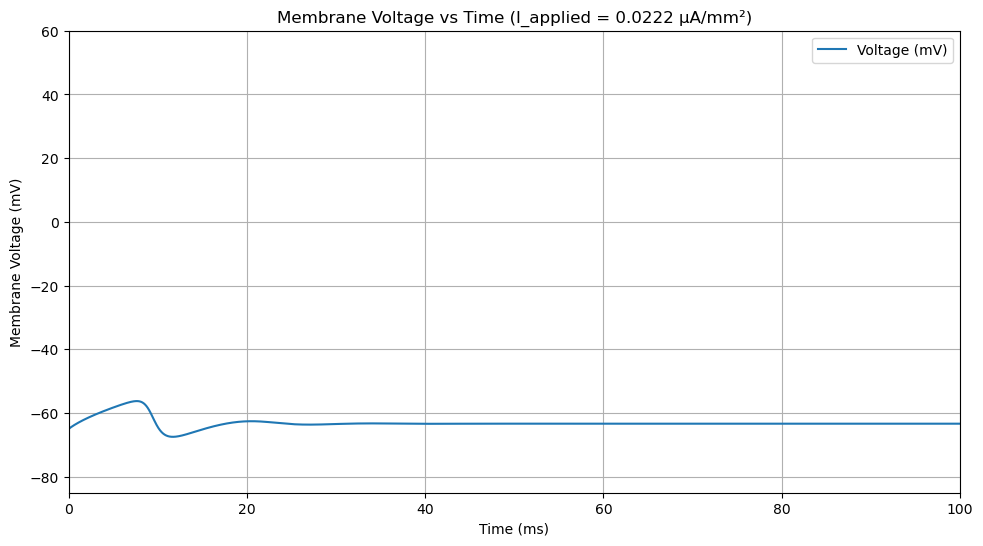

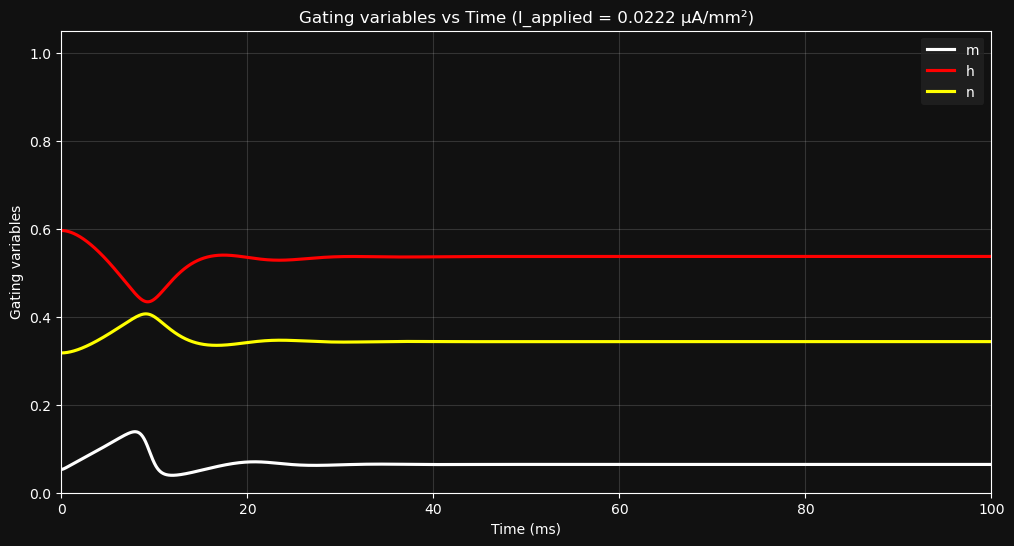

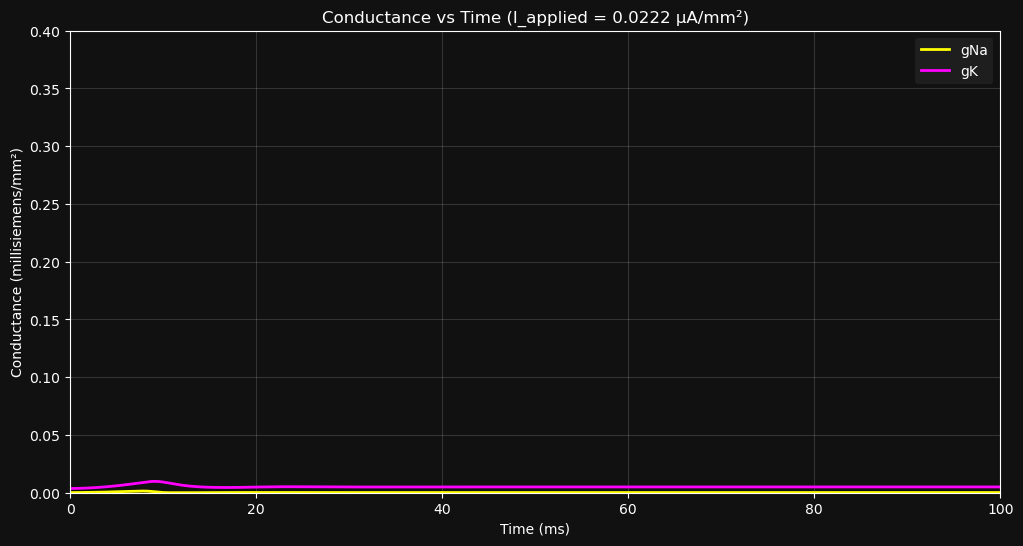

In [3]:
# Demonstrating the region, just at the limit of No APs
hh = HHModel()
_, _, _, _, _, _, _ = hh.model(I_app= 0.0222)
hh.display_VT()
print("\n\n\n")
hh.display_GVT()
print("\n\n\n")
hh.display_CT()

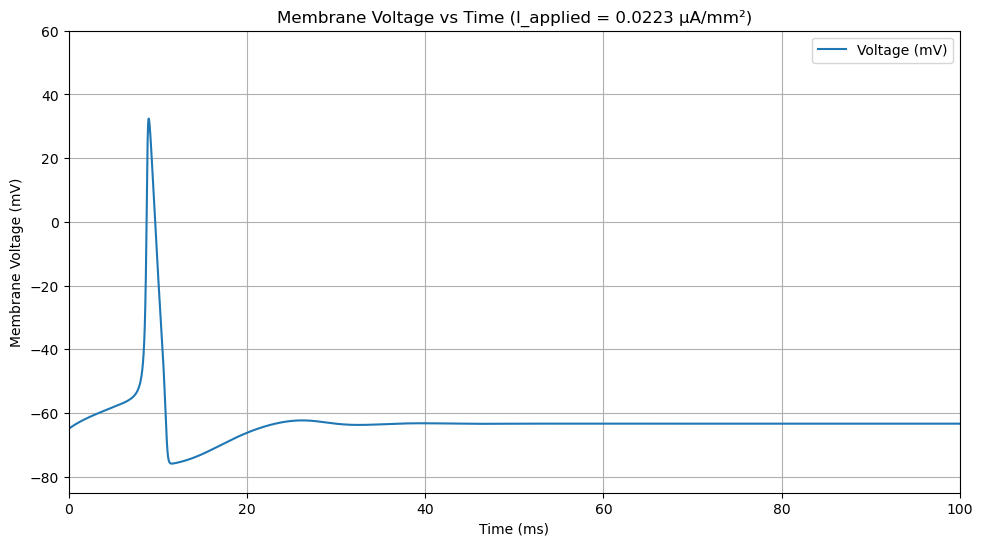

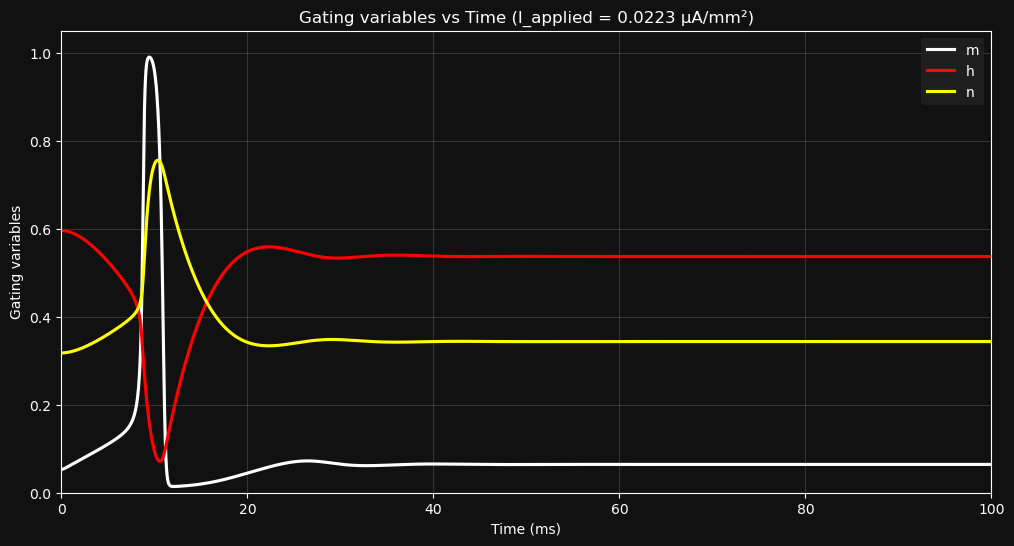

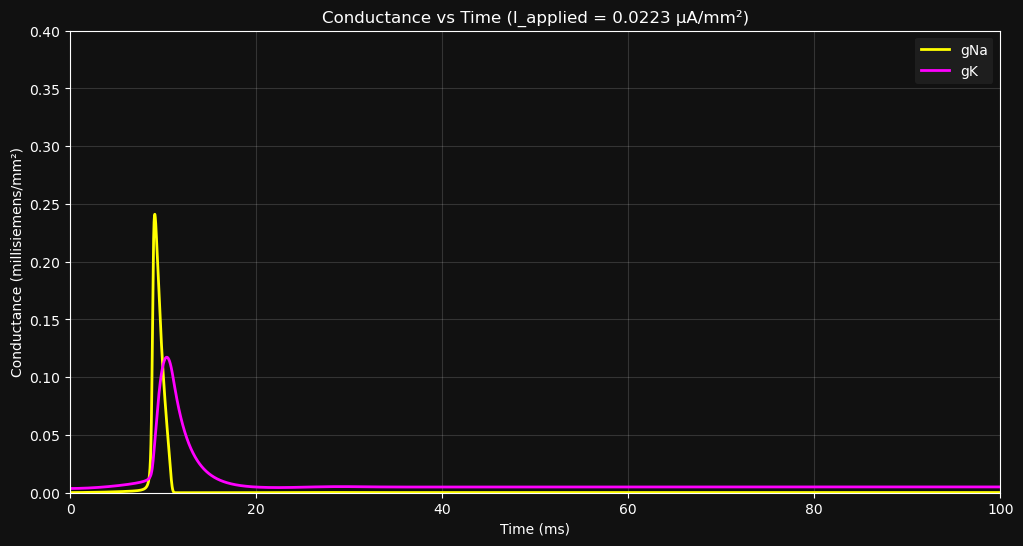

In [4]:
# Demonstrating the region, Single Action potenital generation (Finite AP region starting point)
hh = HHModel()
_, _, _, _, _, _, _ = hh.model(I_app= 0.0223)
hh.display_VT()
print("\n\n\n")
hh.display_GVT()
print("\n\n\n")
hh.display_CT()

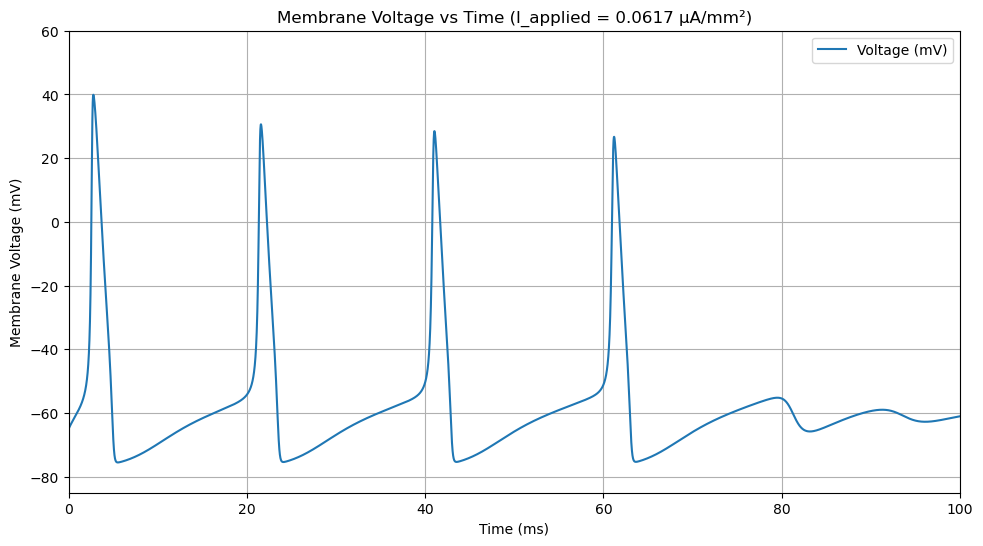

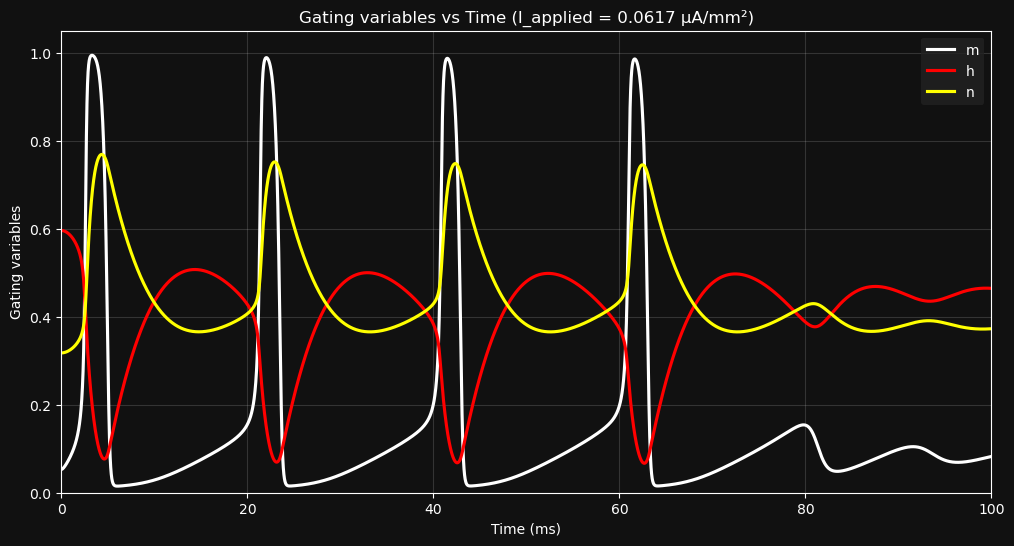

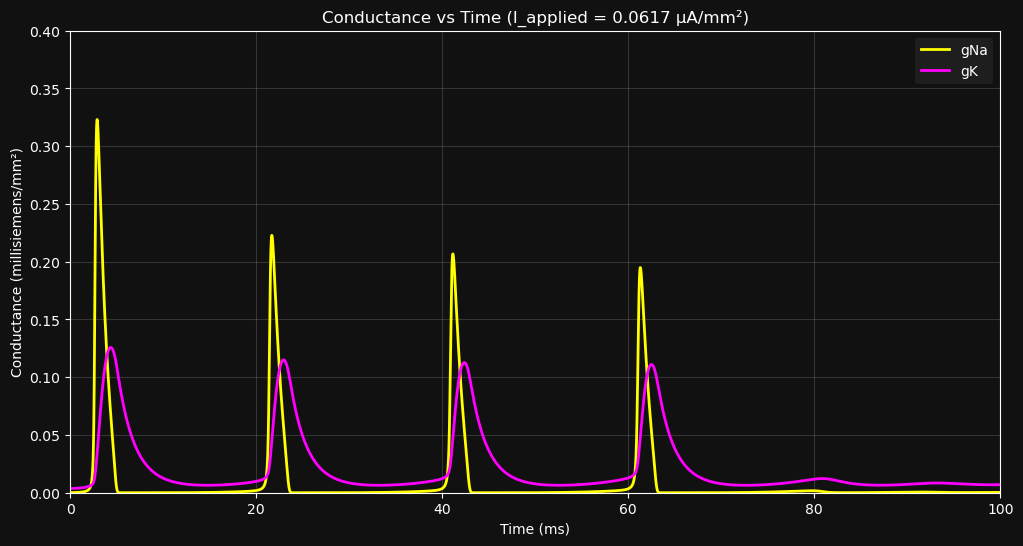

In [5]:
# Demonstrating the region, Three Action potenitals fire (Finite AP region ending point)
hh = HHModel()
_, _, _, _, _, _, _ = hh.model(I_app= 0.0617)
hh.display_VT()
print("\n\n\n")
hh.display_GVT()
print("\n\n\n")
hh.display_CT()

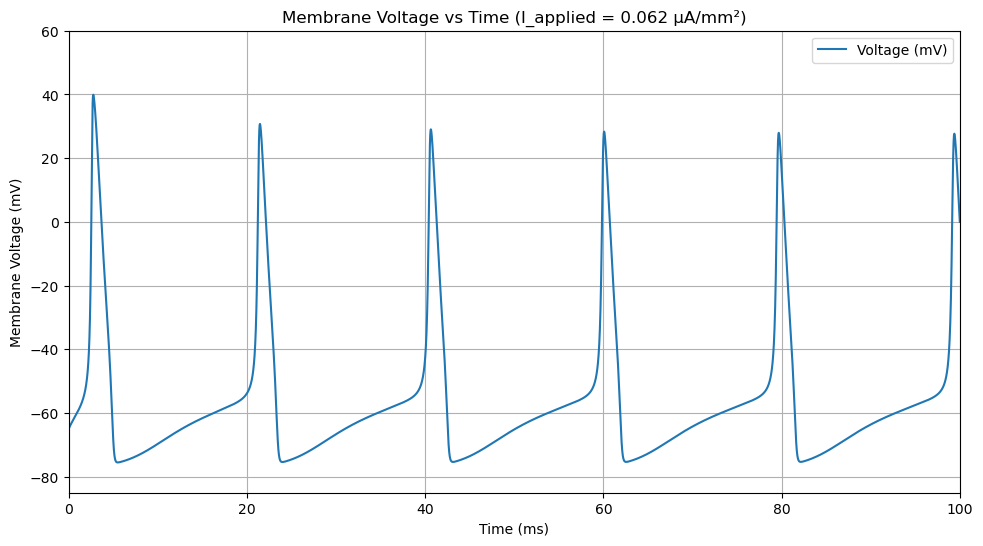

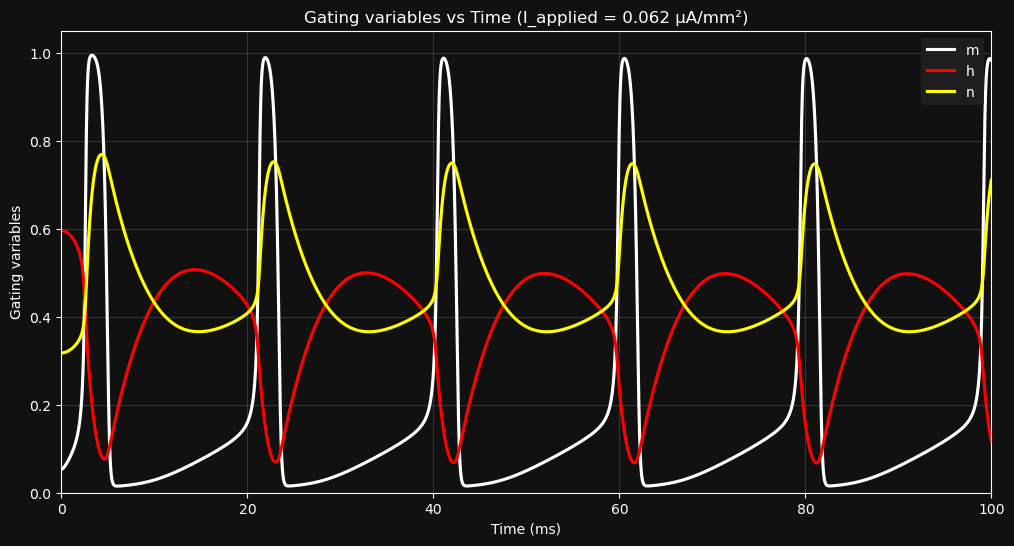

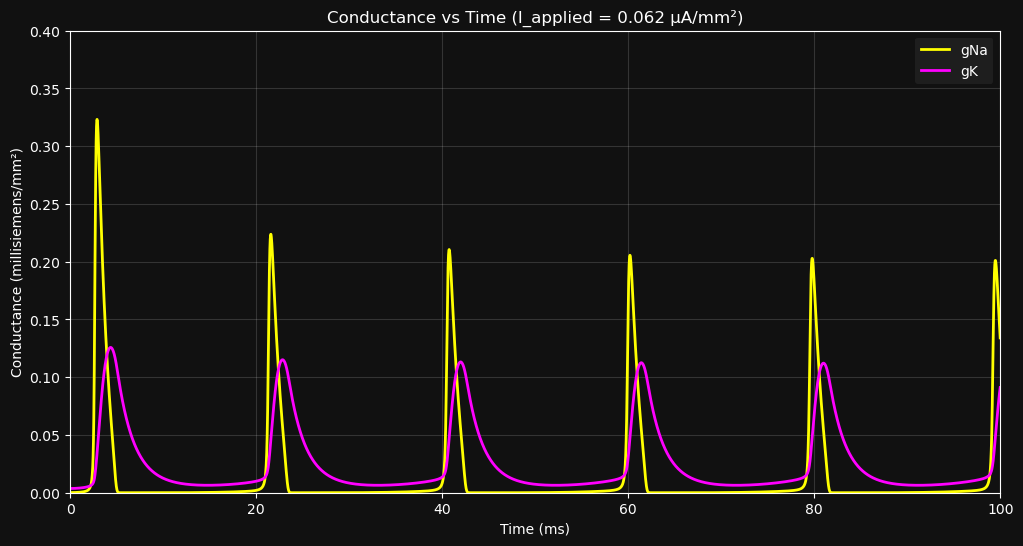

In [6]:
# Demonstrating the region, Initiation of continuous AP firing
hh = HHModel()
_, _, _, _, _, _, _ = hh.model(I_app= 0.062)
hh.display_VT()
print("\n\n\n")
hh.display_GVT()
print("\n\n\n")
hh.display_CT()

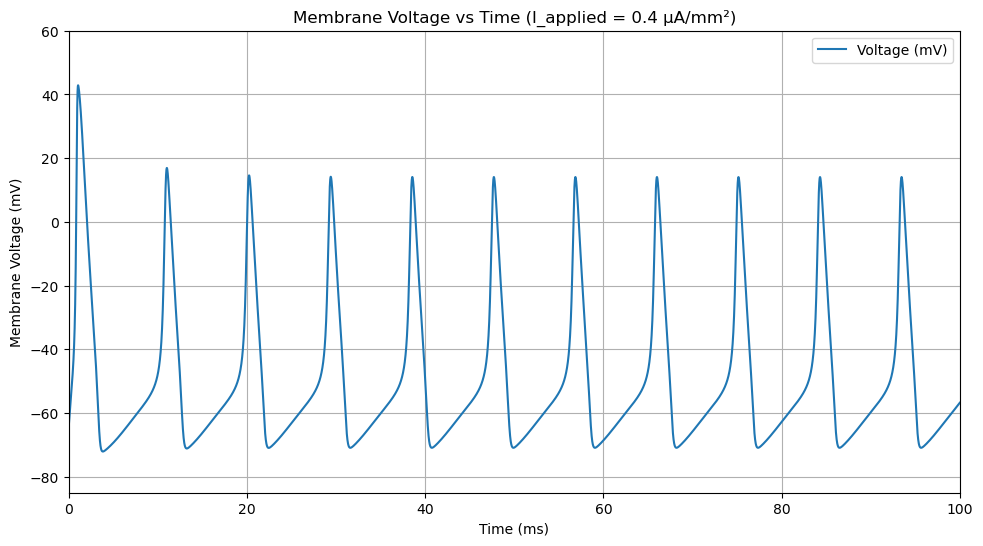

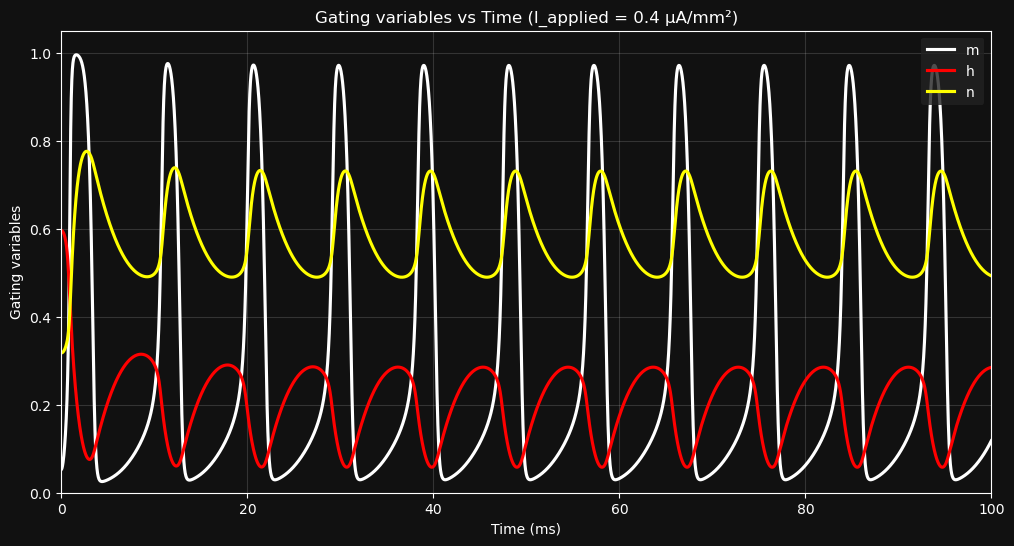

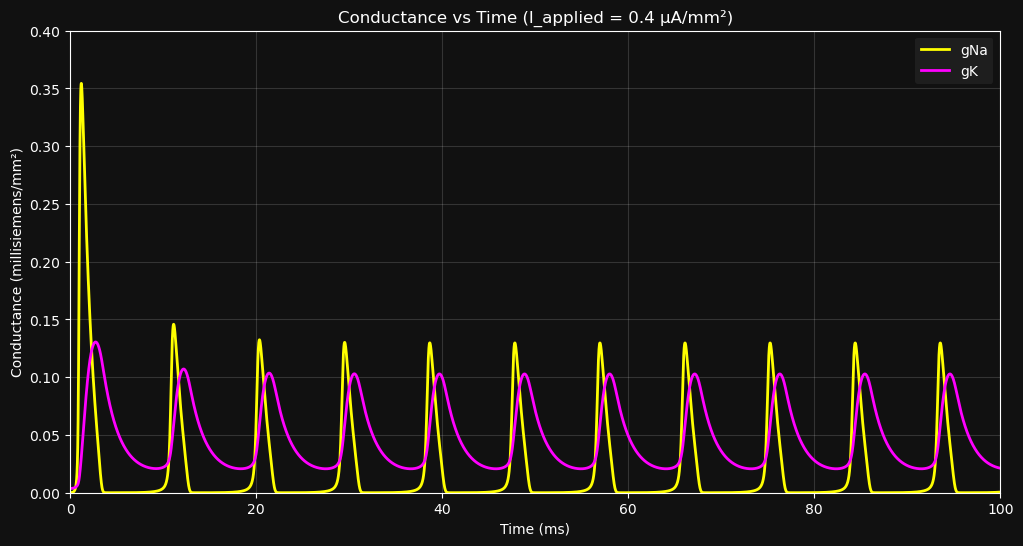

In [7]:
hh = HHModel()
_, _, _, _, _, _, _ = hh.model(I_app= 0.4)
hh.display_VT()
print("\n\n\n")
hh.display_GVT()
print("\n\n\n")
hh.display_CT()

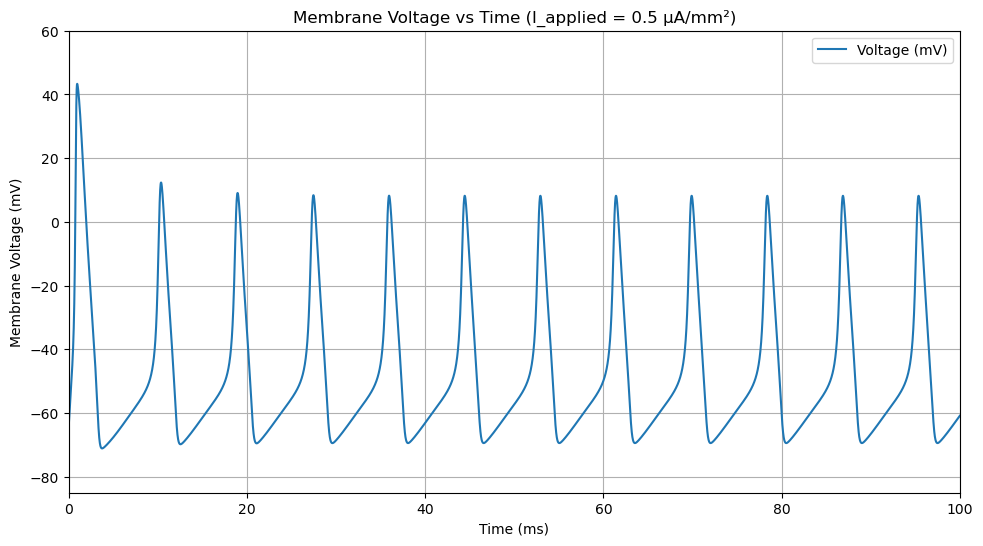

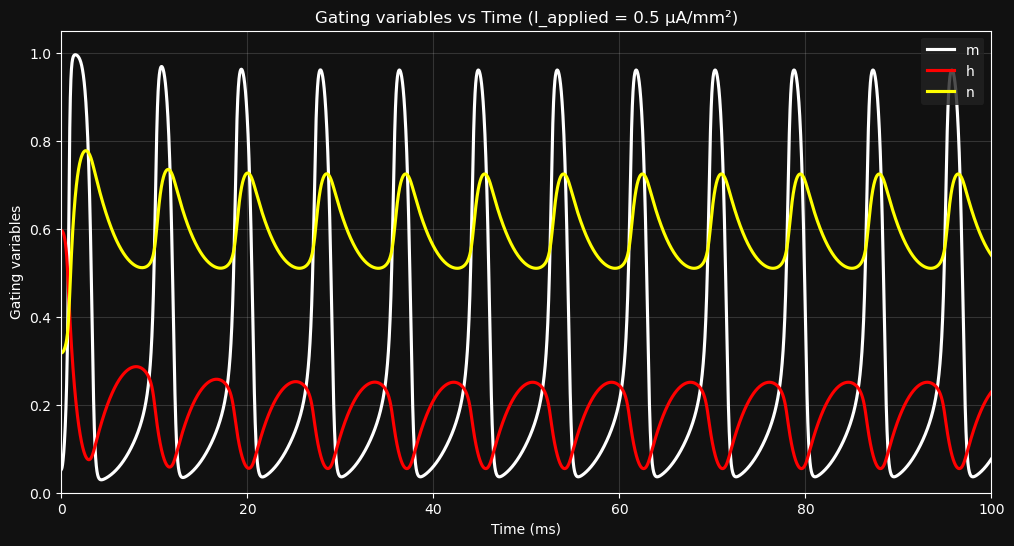

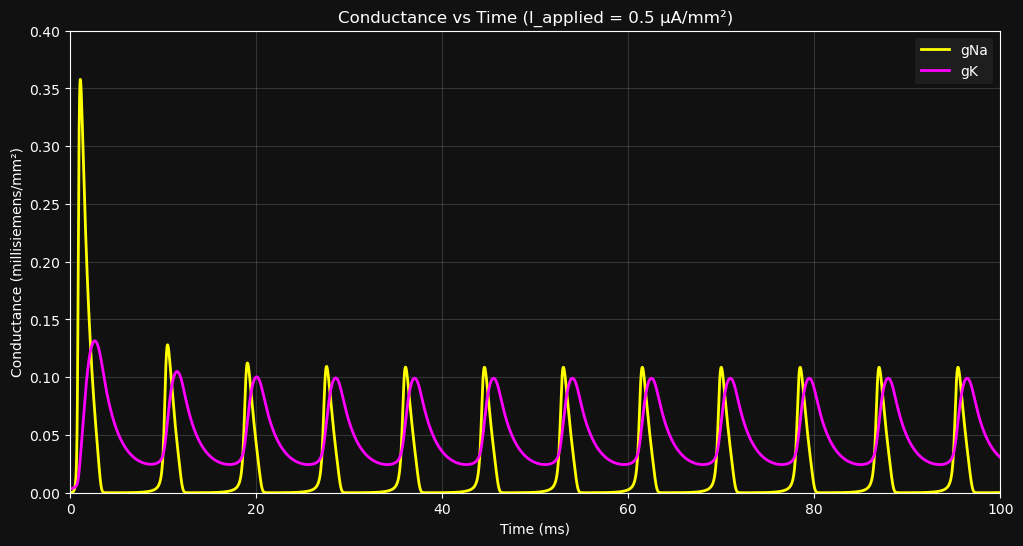

In [8]:
# Demonstrating the region, Periodic function, characteristic of Action Potential is however lost. (The maxima of the peaks lies below 10mV)
hh = HHModel()
_, _, _, _, _, _, _ = hh.model(I_app= 0.5)
hh.display_VT()
print("\n\n\n")
hh.display_GVT()
print("\n\n\n")
hh.display_CT()

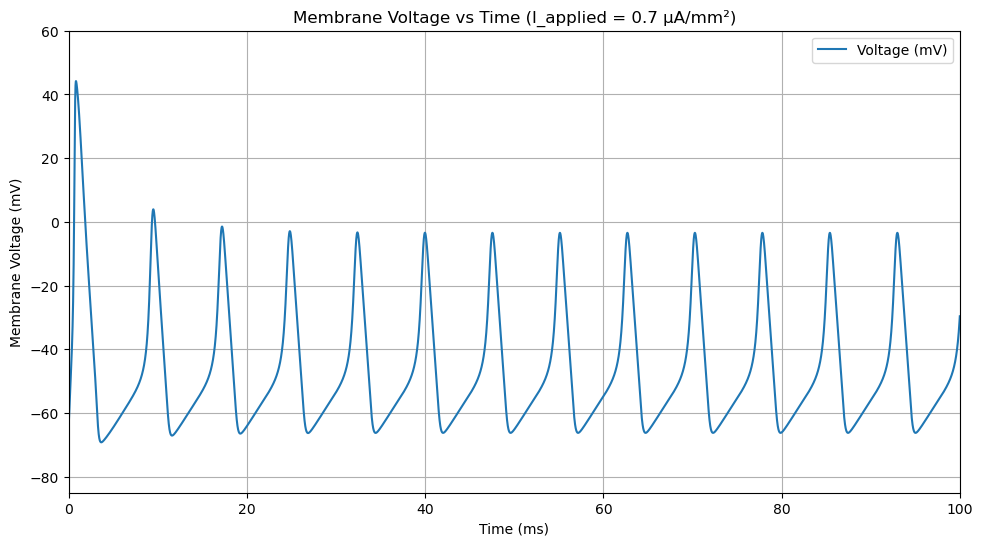

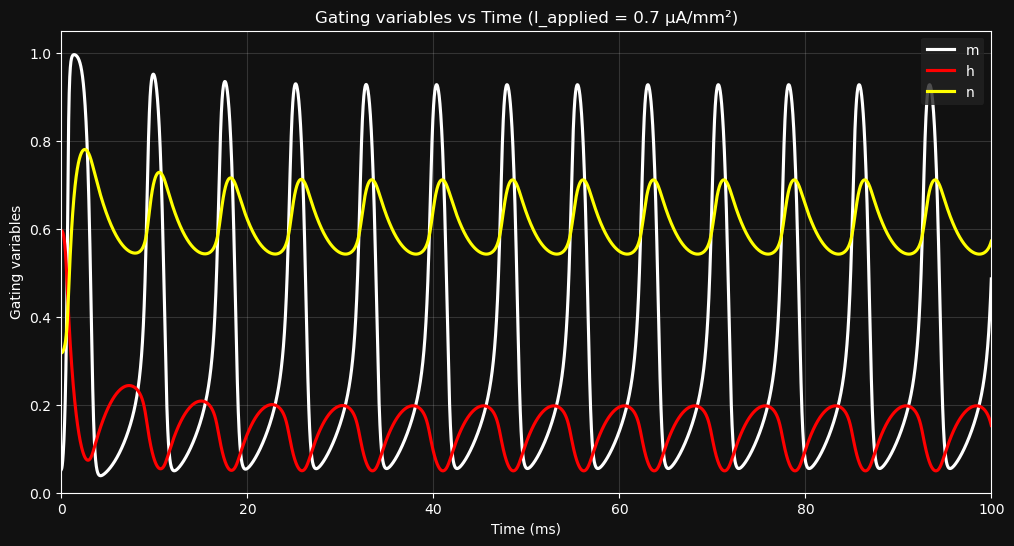

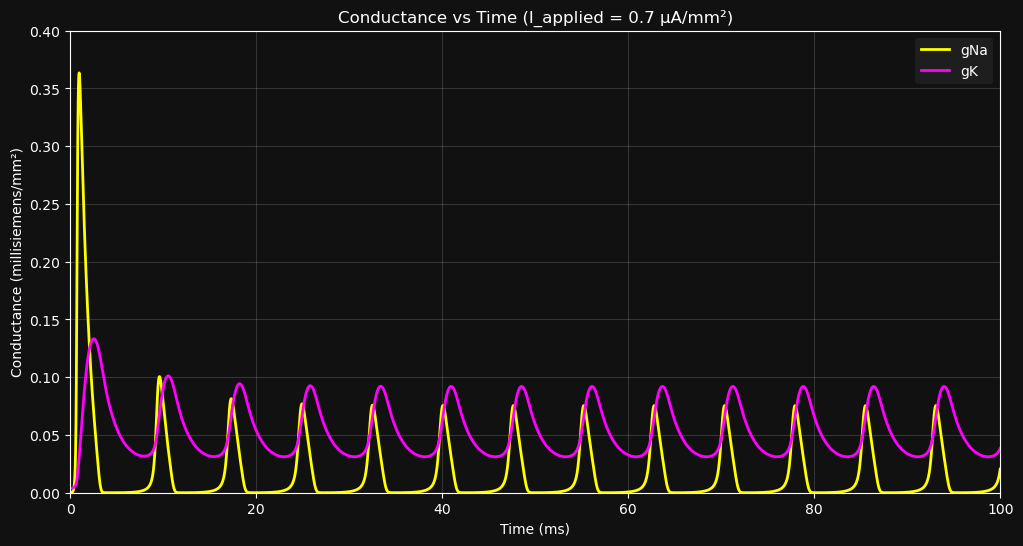

In [9]:
hh = HHModel()
_, _, _, _, _, _, _ = hh.model(I_app= 0.7)
hh.display_VT()
print("\n\n\n")
hh.display_GVT()
print("\n\n\n")
hh.display_CT()

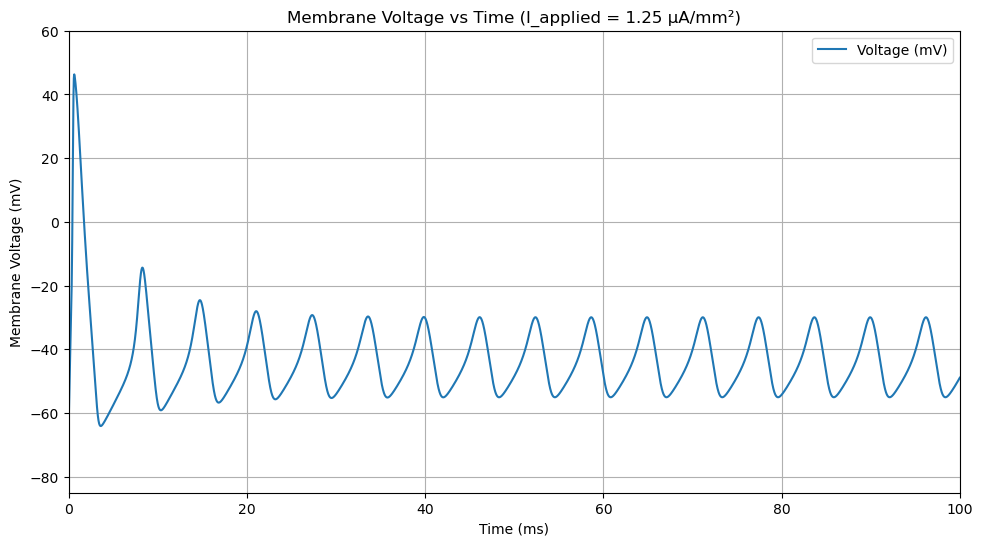

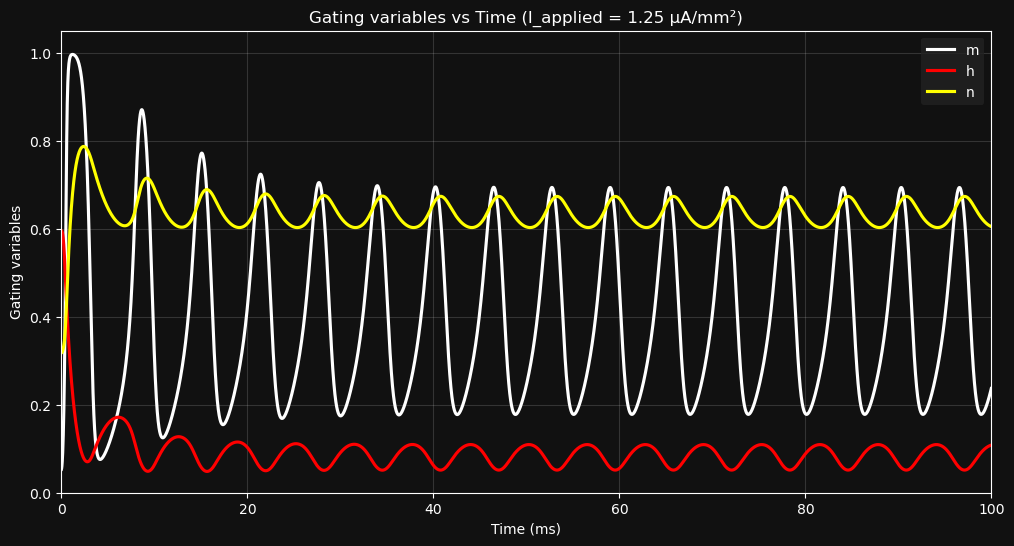

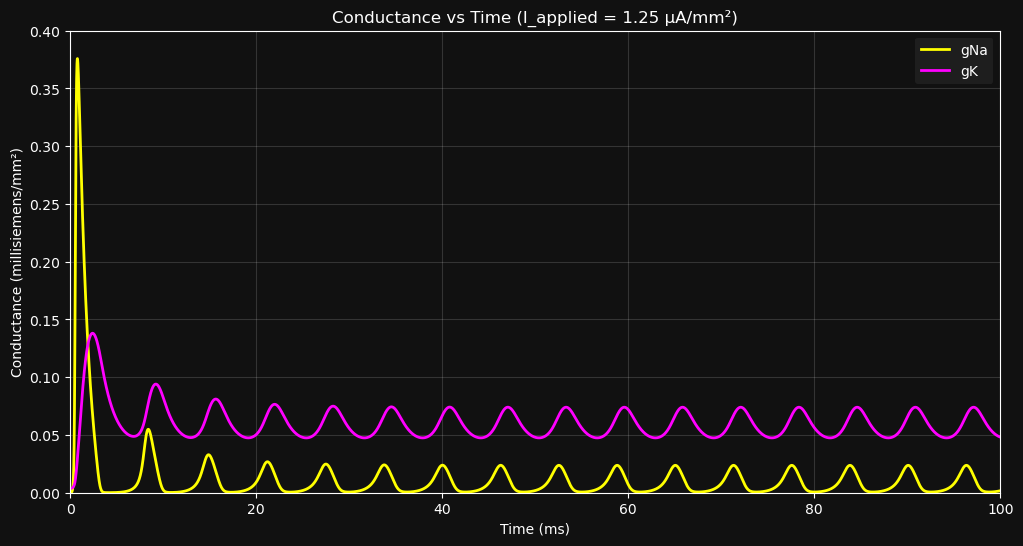

In [10]:
hh = HHModel()
_, _, _, _, _, _, _ = hh.model(I_app= 1.25)
hh.display_VT()
print("\n\n\n")
hh.display_GVT()
print("\n\n\n")
hh.display_CT()

In [11]:
# Sampling for Generating AP Frequency response to different Applied current
frequency_table=[]
current_applied=[]

for n in range(0,8000,50):

    hh = HHModel(dt = 0.01, iter = 100000)

    _, _, _, _, _, _,frequency = hh.model(I_app=(n/10000))

    frequency_table.append(frequency)
    current_applied.append(n/10000)

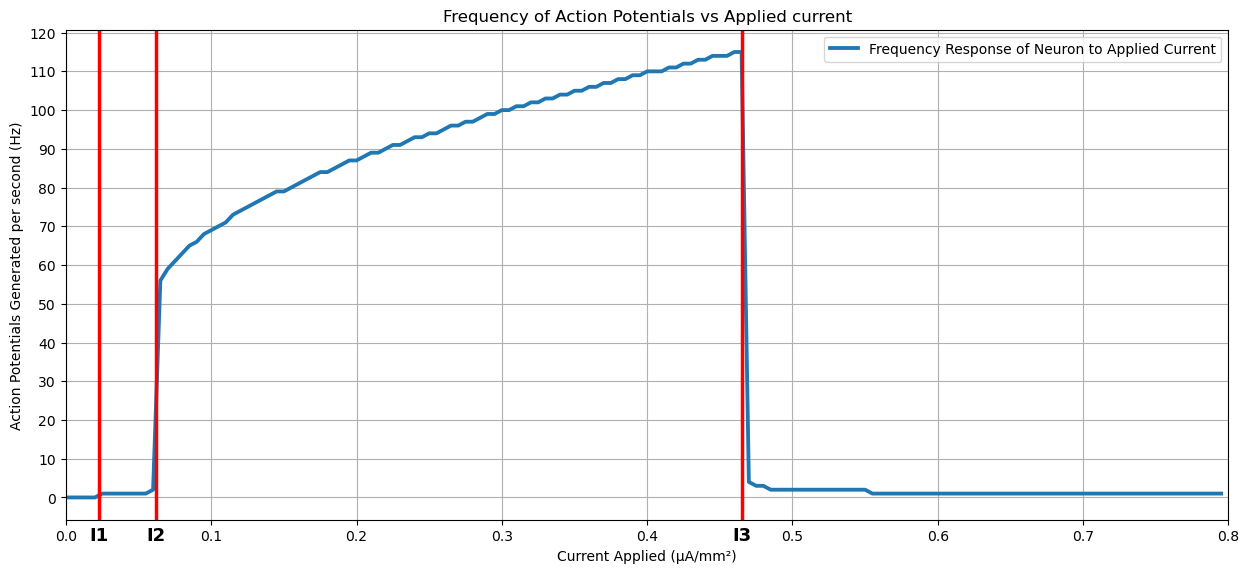

In [12]:
# Plotting frequency of AP firing vs Applied External Current
fig, ax = plt.subplots(figsize=(15, 7))
ax.plot(current_applied, frequency_table, label='Frequency Response of Neuron to Applied Current',lw=2.75)

ax.set_xlabel('Current Applied (μA/mm\u00b2)')
ax.set_ylabel('Action Potentials Generated per second (Hz)')
ax.set_title('Frequency of Action Potentials vs Applied current')
ax.legend()
ax.set_xlim(0, 0.8)
ax.set_xticks(np.arange(0, 0.801, 0.1))
ax.set_yticks(np.arange(0, 121, 10))
ax.grid(True)

# give room below the axes for the labels
fig.subplots_adjust(bottom=0.18)

# vertical lines + bottom labels (outside the plot)
x_vals  = [0.0225, 0.062, 0.465]
labels  = ['I1', 'I2', 'I3']

for x, lab in zip(x_vals, labels):
    ax.axvline(x, color='red', lw=2.5)
    ax.annotate(lab,
                xy=(x, 0), xycoords=('data', 'axes fraction'),
                xytext=(0, -5), textcoords='offset points',
                ha='center', va='top',
                annotation_clip=False,
                fontsize=13,
                fontweight='bold')

plt.show()